In [1]:
import covalent as ct
import numpy as np
import matplotlib.pyplot as plt
from covalent.executor import SlurmExecutor

In [2]:
@ct.electron
def generate_random_matrix(integer_set, nrows, ncols):
    return np.random.choice(integer_set, nrows*ncols).reshape(nrows, ncols)

In [3]:
@ct.electron
def compute_eigenvalues(matrix):
    eig, _ = np.linalg.eig(matrix)
    return eig

In [4]:
@ct.electron
def get_real_part(eigenvalues):
    return [np.real(eig) for eig in eigenvalues]

@ct.electron
def get_imag_part(eigenvalues):
    return [np.imag(eig) for eig in eigenvalues]

### Dispatch the compute heavy task to Slurm

In [5]:
slurm = SlurmExecutor(username="venkat",
                      address="rpi",
                      ssh_key_file="~/.ssh/id_ed25519",
                      conda_env="rpi",
                      remote_workdir="/home/venkat/covalent",
                      poll_freq=30,
                      options={
                          "partition": "rpi-main-debug",
                          "cpus-per-task": 8,
                          "ntasks": 1,
                          "chdir": "/home/venkat/covalent",
                      })

In [6]:
@ct.electron
def batch_compute_eigenvalues(batch_size):
    res = []
    for i in range(batch_size):
        matrix = generate_random_matrix([-1, 0, 1], 5, 5)
        res.append(compute_eigenvalues(matrix))
        
    return (np.asarray(get_real_part(res)).flatten(), np.asarray(get_imag_part(res)).flatten(),)

In [8]:
@ct.lattice(executor=slurm)
def workflow(batch_size):
    return batch_compute_eigenvalues(batch_size)

In [9]:
dispatch_id = ct.dispatch(workflow)(100000)

In [10]:
result = ct.get_result(dispatch_id, wait=True)

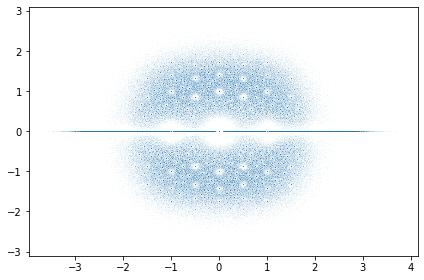

In [11]:
plt.plot(result.result[0], result.result[1],'o', ms=0.01)
plt.tight_layout()
plt.savefig("/home/venkat/bohemian.png", dpi=900)